In [238]:
import pandas as pd
import numpy as np
import re
import spacy

In [239]:
from transformers import DistilBertModel, DistilBertTokenizer
import matplotlib.pyplot as plt
import torch
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [240]:
df = pd.read_csv('Leather_Mag_Text_Cleaned.csv')
df.head(5)

Unnamed: 0                                                URL  \
0           0  http://www.leathermag.com/news/newsstahl-expan...   
1           1  http://www.leathermag.com/news/newsbirkenstock...   
2           2  http://www.leathermag.com/news/newsmacys-inc-r...   
3           3  http://www.leathermag.com/news/newseu-cracks-d...   
4           4  http://www.leathermag.com/news/newsburberry-ad...   

                                               Title  \
0      Stahl expands ZDHC level 3certified portfolio   
1  Birkenstock Posts 1.492 Billion Revenues in Fi...   
2  Macys Inc. Rejects Unsolicited Proposal from A...   
3  EU Cracks Down on Greenwashing and Misleading ...   
4  Burberry Adjusts Financial Outlook Amidst Luxu...   

                                        TitleAndDate  \
0  \nStahl expands ZDHC level 3-certified portfol...   
1  \nBirkenstock Posts €1.492 Billion Revenues in...   
2  \nMacy’s, Inc. Rejects Unsolicited Proposal fr...   
3  \nEU Cracks Down on Greenwashing and Misleadin...   
4  \nBurberry Adjusts Financial Outlook Amidst Lu...   

                                               Texts  
0  \nStahl the world leader in speciality coating...  
1  \nBirkenstock a prominent Germanybased global ...  
2  \nMacys has officially acknowledged the receip...  
3  \nParliament has granted final approval to a d...  
4  \nIn recent update Burberry remains confident ...

In [241]:
df.drop(columns=['Unnamed: 0'], inplace=True)
df.head(5)

URL  \
0  http://www.leathermag.com/news/newsstahl-expan...   
1  http://www.leathermag.com/news/newsbirkenstock...   
2  http://www.leathermag.com/news/newsmacys-inc-r...   
3  http://www.leathermag.com/news/newseu-cracks-d...   
4  http://www.leathermag.com/news/newsburberry-ad...   

                                               Title  \
0      Stahl expands ZDHC level 3certified portfolio   
1  Birkenstock Posts 1.492 Billion Revenues in Fi...   
2  Macys Inc. Rejects Unsolicited Proposal from A...   
3  EU Cracks Down on Greenwashing and Misleading ...   
4  Burberry Adjusts Financial Outlook Amidst Luxu...   

                                        TitleAndDate  \
0  \nStahl expands ZDHC level 3-certified portfol...   
1  \nBirkenstock Posts €1.492 Billion Revenues in...   
2  \nMacy’s, Inc. Rejects Unsolicited Proposal fr...   
3  \nEU Cracks Down on Greenwashing and Misleadin...   
4  \nBurberry Adjusts Financial Outlook Amidst Lu...   

                                               Texts  
0  \nStahl the world leader in speciality coating...  
1  \nBirkenstock a prominent Germanybased global ...  
2  \nMacys has officially acknowledged the receip...  
3  \nParliament has granted final approval to a d...  
4  \nIn recent update Burberry remains confident ...

In [242]:
"""Data Preprocessing: Normalization"""

records = len(df['TitleAndDate']) # total number of rows
missing_values = df.isnull().sum().sum()

if (missing_values > 0):
  print("It has " + str(missing_values) + " missing values.")
else:
  titles = []
  for title in df['Title'].to_list():
    titles.append(re.sub(r'[^\w\s]','',title))

  dates = []
  for i in range(records):
    dates.append(df['TitleAndDate'][i].split("        ")[1].split(" \n")[0])

  texts = []
  for text in df['Texts'].to_list():
    cleaned_text = re.sub(r'[^\w\s.]','',text)
    cleaned_text = re.sub(r'[\n]','',cleaned_text)
    texts.append(cleaned_text)


  df['Title'] = titles
  df['TitleAndDate'] = dates
  df['Texts'] = texts

  df = df.rename(columns={
      'Title': 'Titles',
      'TitleAndDate': 'Dates',
      'Texts': 'News'
  })

df.head(5)

URL  \
0  http://www.leathermag.com/news/newsstahl-expan...   
1  http://www.leathermag.com/news/newsbirkenstock...   
2  http://www.leathermag.com/news/newsmacys-inc-r...   
3  http://www.leathermag.com/news/newseu-cracks-d...   
4  http://www.leathermag.com/news/newsburberry-ad...   

                                              Titles            Dates  \
0      Stahl expands ZDHC level 3certified portfolio  25 January 2024   
1  Birkenstock Posts 1492 Billion Revenues in Fis...  25 January 2024   
2  Macys Inc Rejects Unsolicited Proposal from Ar...  23 January 2024   
3  EU Cracks Down on Greenwashing and Misleading ...  22 January 2024   
4  Burberry Adjusts Financial Outlook Amidst Luxu...  16 January 2024   

                                                News  
0  Stahl the world leader in speciality coatings ...  
1  Birkenstock a prominent Germanybased global fo...  
2  Macys has officially acknowledged the receipt ...  
3  Parliament has granted final approval to a dir...  
4  In recent update Burberry remains confident in...

In [217]:
"""NLP Implementation"""
def process_entities(dataframe):
    # Load the Spacy model once, outside the loop
    nlp = spacy.load("en_core_web_sm")

    entities1 = set()
    entities2 = set()

    # Iterate over rows in the dataframe
    for index, row in dataframe.iterrows():
        # Processing news sentences
        sentences = row['News']
        for sentence in sentences.split('.'):
            doc = nlp(sentence.strip())
            entities1.update([ent.text for ent in doc.ents if ent.label_ == 'ORG'])

        # Processing titles
        title = row['Titles']
        doc = nlp(title.strip())
        entities2.update([ent.text for ent in doc.ents if ent.label_ == 'ORG'])

    return list(entities1.union(entities2))

process_entities(df) # entities

['the Clariant Leather Services',
 'Global Fashion Agenda',
 'Marquette University',
 'Novozymes AS',
 'COVID19 Safety and Prevention Guidelines for the Organisation of Exhibitions',
 'Stahls 2020 ESG Report',
 'the Livonia Innovation Center',
 'World Leather Congress',
 'The International Council of Hides Skins',
 'Bello',
 'the Kenyan Leather Development Council',
 'SpaceOfficial Hotel',
 'Tiffany',
 'The TFL Fashion Centre',
 'Picassian XL762',
 '4Progressive Media Markets Ltd',
 'Bharati',
 'the EMEA Greater China',
 'comAmong',
 'SAPICA',
 'Villa La Favorita',
 'New Lease of Life for Kanpur',
 'the Directorate of Forecasting and Economic Studies DPEE',
 'Leather Naturally Communications',
 'Armani British Home Stores',
 'the Tannery of the Futures',
 'RSS',
 'City Merchandise',
 'Naima Abdullahi',
 'Open House',
 'World Leather',
 'MeattheFacts',
 'USChina',
 'APLF Preview  University of Northampton',
 'the Food Chain and Animal Health',
 'Philip Greens Topshop',
 'VNONCW',
 'Niss

In [219]:
import spacy

# Load the spaCy model
nlp = spacy.load("en_core_web_sm")

def find_words_after_verb(text):
    doc = nlp(text)
    results = []

    for sent in doc.sents:  # Process each sentence in the paragraph
        words_after_verb = []
        verbs_found = False
        for token in sent:
            if token.pos_ == "VERB":
                verbs_found = True
            elif verbs_found and not token.is_stop and not re.match(r"[\.\,\!\?]", token.text):  # Check if token is not a stopword
                words_after_verb.append(token.text)

        # Add the collected words to the results if any words were found after a verb
        if words_after_verb:
            results.append(words_after_verb)

    return results

# Assuming 'df' is a DataFrame with a column "News" containing paragraphs
results = []
for row in df["News"]:
    words_after_verb = find_words_after_verb(row)
    results.append(words_after_verb)

results # products



[[['Zero',
   'Discharge',
   'Hazardous',
   'Chemicals',
   'ZDHC',
   'MRSL',
   '3.1',
   'Gateway',
   'certification',
   '2151',
   'products',
   'portfolio'],
  ['Stahls',
   'ongoing',
   'commitment',
   'ZDHC',
   'mission',
   'highest',
   'standards',
   'sustainable',
   'chemical',
   'management'],
  ['companies',
   'footwear',
   'apparel',
   'accessories',
   'value',
   'chains',
   'commitment',
   'responsible',
   'chemical',
   'management',
   'ultimate',
   'goal',
   'zero',
   'discharge',
   'hazardous',
   'chemicals'],
  ['highest', 'level', 'conformity', 'ZDHC', 'certification', 'programme'],
  ['Stahls',
   'chemical',
   'products',
   'raw',
   'materials',
   'ZDHCs',
   'latest',
   'Manufacturing',
   'Restricted',
   'Substances',
   'List',
   'MRSL',
   '3.1',
   'Eurofins',
   ' ',
   'ChemMAP'],
  ['chemical',
   'management',
   'stewardship',
   'processes',
   'Stahls',
   'manufacturing',
   'sites'],
  ['tirelessly',
   'value',
   'ch

In [220]:
import spacy
from collections import Counter

nlp = spacy.load("en_core_web_sm")

def find_words_after_verb(text):
    doc = nlp(text)
    words_after_verbs = []

    for sent in doc.sents:
        verbs_found = False
        for token in sent:
            if token.pos_ == "VERB":
                verbs_found = True
            elif verbs_found and not token.is_stop and token.text.isalpha():
                words_after_verbs.append(token.text.lower())

    return words_after_verbs

# Assuming 'df' is a pandas DataFrame with a column named "News"
all_words = []
for row in df["News"]:
    words_after_verb = find_words_after_verb(row)
    all_words.extend(words_after_verb)

# Count the words
word_counts = Counter(all_words)

# Convert to a sorted dictionary
sorted_word_counts = dict(word_counts.most_common())

# The 'sorted_word_counts' dictionary now has words as keys, counts as values, sorted by count descending
print(sorted_word_counts)

{'leather': 7586, 'industry': 2411, 'new': 1726, 'million': 1579, 'products': 1562, 'year': 1486, 'market': 1185, 'production': 1150, 'footwear': 1109, 'business': 1092, 'company': 945, 'years': 931, 'fashion': 907, 'international': 862, 'global': 829, 'sector': 799, 'growth': 790, 'value': 735, 'billion': 723, 'product': 720, 'sales': 712, 'tanning': 703, 'goods': 700, 'exports': 679, 'companies': 677, 'materials': 674, 'china': 667, 'quality': 642, 'customers': 628, 'trade': 620, 'environmental': 615, 'development': 608, 'tannery': 596, 'world': 577, 'tanneries': 574, 'brands': 572, 'technology': 570, 'brazilian': 568, 'chemicals': 566, 'hides': 565, 'group': 550, 'sustainability': 535, 'chain': 526, 'process': 518, 'raw': 504, 'luxury': 488, 'supply': 488, 'export': 484, 'material': 480, 'sustainable': 474, 'leathers': 460, 'high': 454, 'time': 452, 'manufacturing': 444, 'industries': 440, 'markets': 433, 'government': 432, 'skins': 427, 'countries': 399, 'automotive': 394, 'local':

In [243]:
print(df.columns)

Index(['URL', 'Titles', 'Dates', 'News'], dtype='object')


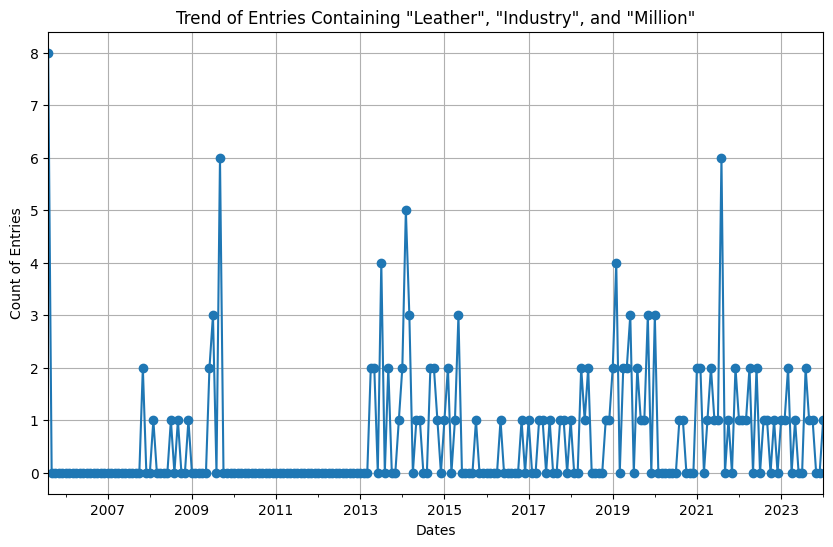

In [248]:

# If 'Dates' is not in datetime format, first convert it without altering the original df
df_temp = df.copy()
df_temp['Dates'] = pd.to_datetime(df_temp['Dates'])

# Define the function to check if all keywords are in a text entry
def contains_all_keywords(text, keywords):
    return all(keyword.lower() in text.lower() for keyword in keywords)

# Keywords list
keywords = ['leather', 'industry', 'million']

# Temporarily add 'Contains_All_Keywords' to df_temp without altering the original df
df_temp['Contains_All_Keywords'] = df_temp['News'].apply(lambda x: contains_all_keywords(x, keywords))

# Filter the DataFrame for rows where all keywords are present using a temporary variable
filtered_df_temp = df_temp[df_temp['Contains_All_Keywords']]

# Ensure the DataFrame is sorted by 'Dates' for accurate time series analysis
filtered_sorted_df = filtered_df_temp.sort_values(by='Dates')

# Count occurrences by date or period (e.g., month)
monthly_counts = filtered_sorted_df.resample('M', on='Dates').size()

# Visualizing the Trend
plt.figure(figsize=(10, 6))
monthly_counts.plot(marker='o', linestyle='-')
plt.title('Trend of Entries Containing "Leather", "Industry", and "Million"')
plt.xlabel('Dates')
plt.ylabel('Count of Entries')
plt.grid(True)
plt.show()


In [250]:
import plotly.express as px

# df['Date'] = pd.to_datetime(df['Date'])

# Filter the DataFrame for the date range 2014 to 2022
df_filtered = df[(df['Dates'] >= '2014-01-01') & (df['Dates'] <= '2022-12-31')]

# Define the function to check if all keywords are in a text entry
def contains_all_keywords(text, keywords):
    return all(keyword.lower() in text.lower() for keyword in keywords)

# Keywords list
keywords = ['leather', 'industry', 'million']

# Apply the function to filter rows where 'News' contains all keywords
df_filtered['Contains_All_Keywords'] = df_filtered['News'].apply(lambda x: contains_all_keywords(x, keywords))

# Filter the DataFrame for rows where all keywords are present
filtered_df = df_filtered[df_filtered['Contains_All_Keywords']]

# Assuming your dates are already sorted; if not, sort them:
filtered_df = filtered_df.sort_values(by='Dates')

# Count occurrences by month within the specified date range
monthly_counts = filtered_df.resample('M', on='Dates').size()

# Convert the series to a DataFrame for plotting
monthly_counts_df = monthly_counts.reset_index(name='Counts')

# Plotting the trend using Plotly for interactivity
fig = px.line(monthly_counts_df, x='Dates', y='Counts', title='Trend of Entries Containing "Leather", "Industry", and "Million" (2014-2022)',
              labels={'Counts': 'Count of Entries', 'Dates': 'Dates'}, markers=True)

# Show the interactive plot
fig.show()


KeyError: 'Dates'

In [251]:
import pandas as pd
import plotly.express as px

# Assuming df['Dates'] is already in datetime format. If not, please convert it as shown:
# df['Dates'] = pd.to_datetime(df['Dates'])

# Continue with the filtered DataFrame as you have it
df_filtered = df[(df['Dates'] >= '2014-01-01') & (df['Dates'] <= '2022-12-31')]

def contains_all_keywords(text, keywords):
    return all(keyword.lower() in text.lower() for keyword in keywords)

keywords = ['leather', 'industry', 'million']

# Assuming df_filtered is your DataFrame filtered by dates and now checking for keywords
df_filtered['Contains_All_Keywords'] = df_filtered['News'].apply(lambda x: contains_all_keywords(x, keywords))

filtered_df = df_filtered[df_filtered['Contains_All_Keywords']].copy()

# Sort and count occurrences by month
monthly_counts = filtered_df.resample('M', on='Dates').size().reset_index(name='Counts')

# Plotting with annotations
fig = px.line(monthly_counts, x='Dates', y='Counts', title='Trend of Entries Containing "Leather", "Industry", and "Million" (2014-2022)',
              labels={'Counts': 'Count of Entries', 'Dates': 'Date'}, markers=True)

# Annotations for hypothetical significant points
annotations = [
    {"x": '2016-01-01', "y": monthly_counts.loc[monthly_counts['Dates'] == pd.Timestamp('2016-01-01'), 'Counts'].max(),
     "text": "Economic Downturn", "arrowhead": 2, "showarrow": True},
    {"x": '2018-01-01', "y": monthly_counts.loc[monthly_counts['Dates'] == pd.Timestamp('2018-01-01'), 'Counts'].max(),
     "text": "Innovation Peaks", "arrowhead": 2, "showarrow": True},
    {"x": '2020-01-01', "y": monthly_counts.loc[monthly_counts['Dates'] == pd.Timestamp('2020-01-01'), 'Counts'].max(),
     "text": "Market Recovery", "arrowhead": 2, "showarrow": True},
]

fig.update_layout(annotations=annotations)

fig.show()


KeyError: 'The grouper name Dates is not found'

In [226]:
import numpy as np
import statsmodels.api as sm
from pandas.tseries.offsets import MonthEnd

# Ensure the 'Dates' column is in datetime format
monthly_counts_df['Dates'] = pd.to_datetime(monthly_counts_df['Dates'])

# Create a numeric 'time' column for regression
monthly_counts_df['time'] = np.arange(len(monthly_counts_df))

# Simple Linear Regression Model
X = sm.add_constant(monthly_counts_df['time'])  # Adds a constant term to the predictor
y = monthly_counts_df['Counts']

model = sm.OLS(y, X).fit()
predictions = model.predict(X)

# Predict future trends for the next 12 months
max_time = monthly_counts_df['time'].max() + 1
future_times = np.arange(max_time, max_time + 12)
X_future = sm.add_constant(future_times)
future_predictions = model.predict(X_future)

# Create a DataFrame for the future predictions
future_dates = pd.date_range(start=monthly_counts_df['Dates'].max() + MonthEnd(1), periods=len(future_times), freq='M')
future_df = pd.DataFrame({'Dates': future_dates, 'Predicted Counts': future_predictions})

# Display the future predictions
print(future_df)

        Dates  Predicted Counts
0  2022-12-31          0.995415
1  2023-01-31          0.997580
2  2023-02-28          0.999745
3  2023-03-31          1.001910
4  2023-04-30          1.004075
5  2023-05-31          1.006240
6  2023-06-30          1.008405
7  2023-07-31          1.010570
8  2023-08-31          1.012735
9  2023-09-30          1.014900
10 2023-10-31          1.017065
11 2023-11-30          1.019230


In [227]:
import plotly.graph_objects as go

# Assuming 'monthly_counts_df' and 'future_df' are prepared as before

# Plotting historical data
fig = go.Figure()
fig.add_trace(go.Scatter(x=monthly_counts_df['Dates'], y=monthly_counts_df['Counts'], mode='lines+markers', name='Historical Counts'))

# Adding predicted future data
fig.add_trace(go.Scatter(x=future_df['Dates'], y=future_df['Predicted Counts'], mode='lines+markers', name='Predicted Counts', line=dict(dash='dash')))

# Adding layout configurations
fig.update_layout(title='Historical and Predicted Word Counts for "Leather", "Industry", and "Million"',
                  xaxis_title='Date',
                  yaxis_title='Word Counts',
                  template='plotly_white')

# Show the plot
fig.show()


In [235]:
df.columns

Index(['Polarity', 'Subjectivity', 'Cluster'], dtype='object')

In [234]:
### Timeline visualization

import plotly.graph_objects as go
from datetime import datetime

# Example data
dates = df['Dates']
events = df['Titles']

# Converting string dates to datetime objects
dates = [datetime.strptime(date, '%d %B %Y') for date in dates]

# Creating a figure
fig = go.Figure()

# Adding events as scatter plot points with hover text
fig.add_trace(go.Scatter(x=dates, y=[1]*len(dates), mode='markers', text=events, hoverinfo='text'))

# Customizing layout
fig.update_layout(title='Interactive Timeline of Events',
                  xaxis_title='Date',
                  yaxis=dict(showticklabels=False),  # Hiding y-axis labels as they are not necessary
                  xaxis=dict(tickformat='%d %B %Y'),
                  showlegend=False,
                  xaxis_rangeslider_visible = True)

# Making the plot interactive and adding a range slider for easier navigation
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(hovermode='closest')

fig.show()

KeyError: 'Dates'

In [229]:
"""Fake News Detection"""
# Lack of labels to detect fake news, classified as unsupervised learning. #


from textblob import TextBlob
news = df['News']
news_count = len(news)

def generate_sentiment(text):
    blob = TextBlob(text)
    sentiment = blob.sentiment
    return sentiment.polarity, sentiment.subjectivity

polarity, subjectivity = list(), list()
for i in range(news_count):
    pol, subj = generate_sentiment(news[i])  # 'news' is a Pandas Series
    polarity.append(pol)
    subjectivity.append(subj)

df['Polarity'] = polarity
df['Subjectivity'] = subjectivity
df

URL  \
0     http://www.leathermag.com/news/newsstahl-expan...   
1     http://www.leathermag.com/news/newsbirkenstock...   
2     http://www.leathermag.com/news/newsmacys-inc-r...   
3     http://www.leathermag.com/news/newseu-cracks-d...   
4     http://www.leathermag.com/news/newsburberry-ad...   
...                                                 ...   
1715  http://www.leathermag.com/news/newsthe-influen...   
1716  http://www.leathermag.com/news/newswollsdorf-l...   
1717  http://www.leathermag.com/news/newsfootwear-tr...   
1718  http://www.leathermag.com/news/newseuropean-de...   
1719  http://www.leathermag.com/news/newschris-danie...   

                                                 Titles      Dates  \
0         Stahl expands ZDHC level 3certified portfolio 2024-01-25   
1     Birkenstock Posts 1492 Billion Revenues in Fis... 2024-01-25   
2     Macys Inc Rejects Unsolicited Proposal from Ar... 2024-01-23   
3     EU Cracks Down on Greenwashing and Misleading ... 2024-01-22   
4     Burberry Adjusts Financial Outlook Amidst Luxu... 2024-01-16   
...                                                 ...        ...   
1715  The influence of the fatliquor on the physicoc... 2005-08-01   
1716                            Wollsdorf Leder expands 2005-08-01   
1717                 Footwear trends autumnwinter 20067 2005-07-28   
1718                  European delegation visits Brazil 2005-07-28   
1719                       Chris Daniel Tyson Foods Inc 1969-12-31   

                                                   News  \
0     Stahl the world leader in speciality coatings ...   
1     Birkenstock a prominent Germanybased global fo...   
2     Macys has officially acknowledged the receipt ...   
3     Parliament has granted final approval to a dir...   
4     In recent update Burberry remains confident in...   
...                                                 ...   
1715  SummaryThe aim of the present survey is to det...   
1716                      In order to meet increased...   
1717                      Amsterdambased forecasting...   
1718                      From July 1724 the Preside...   
1719  Tanneries and locations Tyson operate four cat...   

      Contains_All_Keywords  Polarity  Subjectivity  
0                     False  0.273237      0.743109  
1                     False  0.164360      0.404425  
2                     False  0.049306      0.339647  
3                     False  0.216667      0.499040  
4                     False  0.185934      0.552652  
...                     ...       ...           ...  
1715                  False  0.022024      0.329764  
1716                  False -0.054329      0.367316  
1717                  False  0.227396      0.521677  
1718                  False  0.104630      0.239815  
1719                  False  0.010000      0.453333  

[1720 rows x 7 columns]

In [32]:

# print(fakes, neutrals, reals)

32 1581 1827


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

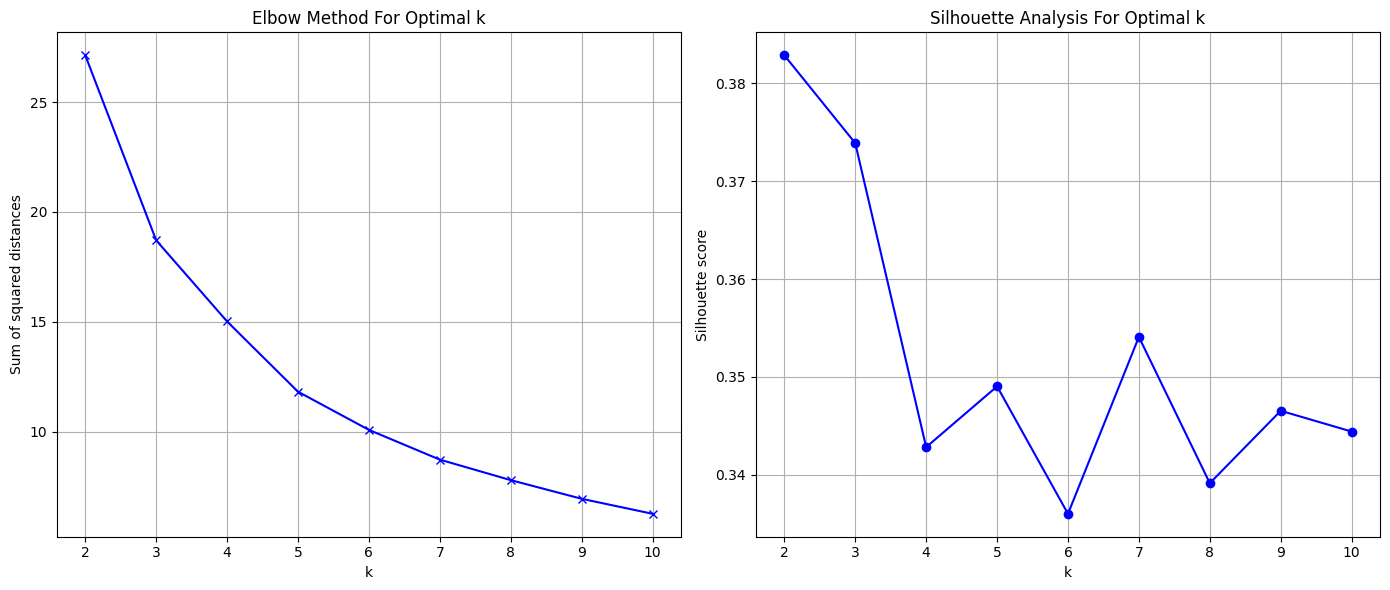

In [230]:
from sklearn.metrics import silhouette_score

# Range of K to try
K_range = range(2, 11)

# For storing results
sum_of_squared_distances = []
silhouette_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(df[['Polarity', 'Subjectivity']])
    sum_of_squared_distances.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(df[['Polarity', 'Subjectivity']], kmeans.labels_))

# Plotting the Elbow Method
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(K_range, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.grid(True)

# Plotting the Silhouette Analysis
plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, 'bo-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Silhouette Analysis For Optimal k')
plt.grid(True)

plt.tight_layout()
plt.show()


In [231]:
from sklearn.cluster import KMeans

# Assuming df is your DataFrame and it has 'Polarity' and 'Subjectivity' columns
features = df[['Polarity', 'Subjectivity']]

# Apply K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=0).fit(features)

# Cluster labels
clusters = kmeans.labels_

# Add cluster labels to your DataFrame
df['Cluster'] = clusters

# Review the centroids to understand your clusters
centroids = kmeans.cluster_centers_
print(centroids)

# Based on the centroids, manually map cluster labels to Fake, Neutral, Real
# This mapping might need adjustment based on your analysis of the centroids
mapping = {0: 'Real', 1: 'Fake', 2: 'Neutral'}
df['News_Type'] = df['Cluster'].map(mapping)

# Count the new distribution
new_distribution = df['News_Type'].value_counts()
print(new_distribution)


[[0.21149637 0.50870471]
 [0.07494113 0.37776911]
 [0.02573196 0.15577579]]
News_Type
Fake       932
Real       544
Neutral    244
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [233]:
df

Polarity  Subjectivity  Cluster
0    0.121716      0.566158        2
1   -0.015894      0.507737        1
2    0.246636      0.621169        2
3   -0.166245      0.108689        1
4    0.041380      0.456390        2
..        ...           ...      ...
995  0.005314      0.454046        1
996 -0.241588      0.442519        1
997 -0.106065      0.474364        1
998 -0.101545      0.515215        1
999 -0.399133      0.276009        1

[1000 rows x 3 columns]

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



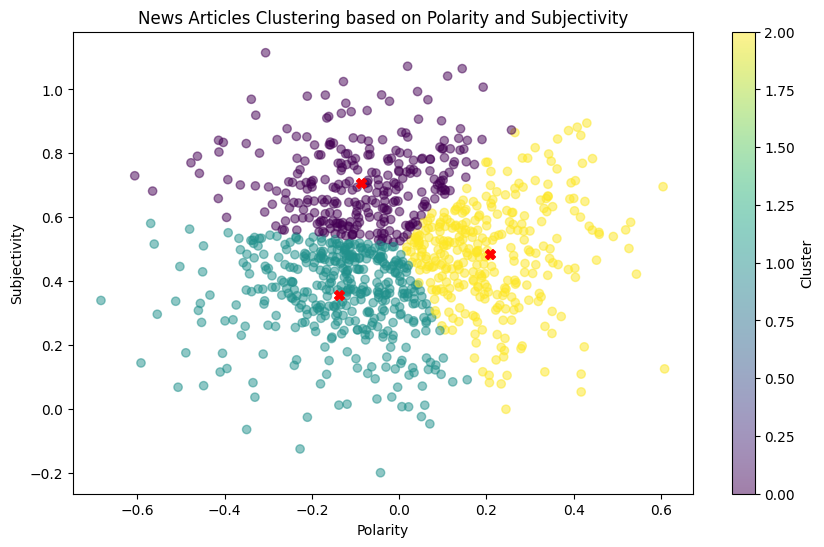

In [232]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Simulated polarity and subjectivity scores for demonstration purposes
# Let's create a DataFrame similar in structure to the user's data
import pandas as pd
import numpy as np

# np.random.seed(0)  # For reproducibility

# Generating some example data
polarity = np.random.normal(loc=0, scale=0.2, size=1000)  # Normal distribution centered at 0
subjectivity = np.random.normal(loc=0.5, scale=0.2, size=1000)  # Normal distribution centered at 0.5

# Combining into a DataFrame
df = pd.DataFrame({'Polarity': polarity, 'Subjectivity': subjectivity})

# Apply K-Means Clustering with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42).fit(df)

# Cluster labels
df['Cluster'] = kmeans.labels_

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(df['Polarity'], df['Subjectivity'], c=df['Cluster'], cmap='viridis', alpha=0.5)
plt.title('News Articles Clustering based on Polarity and Subjectivity')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.colorbar(label='Cluster')
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50, marker='X')  # Marking the centroids
plt.show()
